# Tesis GBM: Dynamics of Bargaining Power
# Multi Objective Dynamic Model - Continuous Actions
# With Dynamics of Bargaining Power (MODPA2) 

#### Genaro Basulto Mejía
#### 2022 

This code was made specifically to solve the dynamic multi-objective principal-agent model with continuous actions.  

This aplication uses the JuMP library and the Ipopt solver to solve the optimization problrem given a value for the bargaining power.

The use uf this library allows us to easily change the parametrization of the problem and rely on a robust solver to find solutions in multi-criteria non-linear restricted optimization problems. 

## Libraries

In [17]:
using DataFrames
using XLSX
using JuMP # Loading optimization libraries.
using Ipopt # Ipopt solve a nonlinear optimization problem.
using ExcelFiles  # Loading excel files libraries.
using Colors, ColorSchemes

## Utility Functions

In [46]:
#v(c,a,g=1,alpha=1)=-exp(g*(a-alpha*c))  # Declaration of v (agent utility function); 
                                        # g is the coefficient of risk aversion
                                        # alpha is a cost coefficientv

v(c, h=0.50) =  (c^(1-h))/(1-h) #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort

u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent

paretopdf(a,L,H,x) = (a*(L^a)*(x^(-a-1)))/(1-(L/H)^a)
paretocdf(a,L,H,x) = (((L/x)^a)*log(x/L)*(1-(L/H)^a)-((L/H)^a)*log(H/L)*(1-(L/x)^a))/((1-(L/H)^a)^2)
#(1-(L/x)^(a))/(1-(L/H)^a)

paretocdf (generic function with 1 method)

## Variables and Lists

In [53]:
Y = [0.4 0.8]    # Outcomes set [yl yh]
co = 2
h = 0.5 #Parameter for agent utility 
beta = 0.96 #Temporal Discount Factor
digits_tol = 3 #Digits of precision 
Max_iter = 200 #Limit of method iterations

200

## Model Specification 

In [54]:
function Solve_Model(h, delta, P, Q, U0, V, start_xl = Y[1]/2, start_xh = Y[2]/2, L=Y[1], H=Y[2], x = (Y[1]+Y[2])/2)
    """
    This functions declares and solves the model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model = Model(
            with_optimizer(
                Ipopt.Optimizer, 
                tol = 1e-7, 
                max_iter = 1000,
                print_level=0)) 

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model, xl >= 0.00001, start = start_xl)  # xl = wl, low compensation.
    @variable(model, xh >= 0.00001, start = start_xh)  # xh = wh, hight compensation.
    @variable(model, a >= 0.1, start = 1)  # Optimal action
    
     # Declare the agent's utility function within the model.
    register(model, :v, 2, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********
    register(model, :u, 2, u, autodiff=true) 
    register(model, :paretocdf, 4, paretocdf, autodiff=true) 
    register(model, :paretopdf, 4, paretopdf, autodiff=true)  
    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV = @NLexpression(model, paretocdf(a,L,H,x)*(v(xh,h)+beta*V[P])+(1-paretocdf(a,L,H,x))*(v(xl,h)+beta*V[Q])-a)  # E(v|a)
    EU = @NLexpression(model, paretocdf(a,L,H,x)*(u(Y[2],xh)+beta*U0[P])+(1-paretocdf(a,L,H,x))*(u(Y[1],xl)+beta*U0[Q])) #E(U|a)

    # Objective function; expected utility of the principal and the agent given ah.
    @NLobjective(model, Max, delta*EV+(1-delta)*EU) 

    @constraint(model, xh<=Y[2])  # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model, xl<=Y[1])  # Financial capacity restriction for low compensation; wl<=yl.
    @NLconstraint(model,  paretopdf(a,L,H,x)*(v(xh,h)-v(xl,h))-1 == 0)
    
    # The problem for incentive ah is solved.
    JuMP.optimize!(model) 

    #The optimal values are saved and returned
    wh = value(xh)
    wl = value(xl)
    a_opt = value(a)
    u_opt = paretocdf(a_opt,L,H,x)*(u(Y[2],wh)+beta*U0[P])+(1-paretocdf(a_opt,L,H,x))*(u(Y[1],wl)+beta*U0[Q])
    v_opt = paretocdf(a_opt,L,H,x)*(v(wh,h)+beta*V[P])+(1-paretocdf(a_opt,L,H,x))*(v(wl,h)+beta*V[Q])-a_opt
    return u_opt, v_opt, wl, wh, a_opt, termination_status(model)
end

Solve_Model (generic function with 6 methods)

### Feasable Bargaining Powers

In [55]:
function min_delta(h, eps)
    """
    This function returns the minimun bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 0 
    #Solve high effort for delta_0 = 0
    u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1))
    while stat == MOI.LOCALLY_INFEASIBLE
        delta += eps 
        u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1))
    end
    vf = copy(v_opt) 
    #Search delta_t such that we find interior solution 
    while round.(v_opt,digits = 5) == round.(vf,digits = 5) 
        delta += eps #Update delta_t
        #Solve high effort for delta_t
        u_opt, vf, xl, xh, a, stat_high = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1))
    end
    return delta - eps #Return delta_min 
end


function max_delta(h, eps)
    """
    This function returns the maximum bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 1
    #Solve high effort for delta_0 = 1
    u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1))
    while stat == MOI.LOCALLY_INFEASIBLE
        u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1), Y[1], Y[2])
        if stat == MOI.LOCALLY_SOLVED
            break 
        else
            delta -= eps
            u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, 1, 1, zeros(1), zeros(1))
        end
    end
    vf = copy(v_opt)
    #Search delta_t such that we find interior solution 
    while round.(v_opt,digits = 5) == round.(vf,digits = 5)
        delta -= eps
        #Solve high effort for delta_t
        u_opt, vf, xl, xh, a, stat_high = Solve_Model(h, delta, 1, 1, zeros(1),zeros(1))
    end
    return delta + eps #return delta_max
end

max_delta (generic function with 1 method)

In [56]:
eps = 0.02 #Dynamic of the bargaining power parameter 
dl = min_delta(h, eps)
dh = max_delta(h, eps)
println(dl,dh)
n = trunc(Int, ceil((dh-dl)*(co/eps)+1)) #Bargaining power number of intervals
V = zeros(n) # State variable's initial value vector  
VF =  zeros(n) # State variable's final value vector  
UF = zeros(n) # List of final values of the principal utility
U0 = ones(n) # State variable's initial value
Deltas = LinRange(round(dl, digits = 2), round(dh, digits = 2),n) #List of admisible bargaining powers

0.020.39999999999999947


39-element LinRange{Float64}:
 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,…,0.34,0.35,0.36,0.37,0.38,0.39,0.4

## Routine 

In [57]:
function Dynamic_Pareto_Frontier(Deltas, n, V, VF, U0, UF, digits_tol, Max_iter, h)
    """
    This functions finds the stationary point of the Bellman Equation for 
    the multi objective dynamic model with bargaining power dynamics
    Returns optimal values if found 
    """
    iter=0 #numero de iteraciones para enontrar el punto estacionario 
    AcOpt = [] # List of optimal actions for K
    WHOpt = [] # List of hight optimal compensation for K
    WLOpt = [] # List of low optimal compensation for K
    DFH=ones(n).*n #List of next period promised bargaining power if output yh occurs
    DFL=ones(n) #List of next period promised bargaining power if output yl occurs

    while round.(U0,digits = digits_tol)!=round.(UF,digits = digits_tol)  #loop to find thestationary point of the principal Utility
    
        AcOpt=[] # List of optimal actions for K
        WHOpt=[] # List of hight optimal compensation for K
        WLOpt=[] # List of low optimal compensation for K
        U0=UF #Update of the state variable (Princial Utility)
        V = VF #Update of the state variable (Agent Utility)
        UF=zeros(n) #Inital Value in the loop for Princial Utility
        VF = zeros(n) #Inital Value in the loop for Agent Utility
        
        for d in 1:n #Loop for bargaining powers
            
            delta = Deltas[d] #Current bargaining power
            uval = -10000 #Initialization of the agent utility for the current bargaining power
            vval = -10000 #Initialization of the principal utility for the current bargaining power
            wl=0 #Initialization of the low compensation for the current bargaining power
            wh=0 #Initialization of the high compensation for the current bargaining power
            accopt=0 #Initialization of the recomended effort for the current bargaining power
            p=0 #Initialization of the promised bargaining power|yh 
            q=0 #Initialization of the promised bargaining power|yl
            val = -10000 #Initialization of the weighted sum of the agent and pricial's utilities for the current bargaining power
            P = min(d+co, n) #Index for the next period bargaining power if output yh is observed
            Q = max(d-1, 1) #Index for the next period bargaining power if output yl is observed
                    
            #Solve the model given the current bargaining power
            u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, P, Q, U0, V) 
            
           # if stat == MOI.LOCALLY_INFEASIBLE 
            #    u_opt, v_opt, xl, xh, a, stat = Solve_Model(h, delta, P, Q, U0, V, Y[1], Y[2])
            #end

            #If the weighted sum of utilities is higher than it's last value
            if (delta*v_opt+(1-delta)*u_opt>val) & (stat == MOI.LOCALLY_SOLVED) 
                val = delta*v_opt+(1-delta)*u_opt #Update sum of utilities 
                uval=u_opt #Update optimal value for the princial utility
                vval = v_opt #Update optimal value for the agent utility
                wh=xh #Update optimal value for the high compensation 
                wl=xl #Update optimal value for the low compensation
                accopt= a #Udate optimal reccomended action                       
            end
            
            #Save all optimal values for the current bargaining power
            UF[d] = uval 
            VF[d] = vval 
            append!(WHOpt, wh)
            append!(WLOpt,wl)
            append!(AcOpt, accopt)
            DFH[d] = P
            DFL[d] = Q
            
            if iter<=1 
                #Print Results
                print("Delta= ", delta, "  u=", uval,"   wh=", wh, "   wl=", wl, "  P=",P,"  Q=",Q,"  Acc= ", accopt, "\n")
            end
        end
        
        iter+=1 #Update iteration counter
        println(iter) #Print current iteration 
        
        if iter == Max_iter #If number of iteration reaches max, finish the method.
            break
        end

    end
    #Save stationary result of all variables in dataframe 
    DataEstPoint = DataFrame(
    Deltas = Deltas,
    Utilidad_Agente=VF,
    Utilidad_Principal=UF,
    Compensacion_YH=WHOpt,
    Compensacion_YL=WLOpt,
    Accion_Recomendada=AcOpt, 
    DFH=DFH, 
    DFL=DFL)
    
    return DataEstPoint #Return Dataframe 
end

Dynamic_Pareto_Frontier (generic function with 1 method)

In [58]:
#Execution of the method
DataEstPoint_MOWS = Dynamic_Pareto_Frontier(Deltas, n, V, VF, U0, UF, digits_tol, Max_iter, h) 
save("Continuous_Actions/ModTesis_eps02_y0408_h05.xlsx", DataEstPoint_MOWS) #Save data of stationary point to excel

Delta= 0.02  u=0.42972651929973227   wh=0.04510312888210322   wl=1.0e-5  P=3  Q=1  Acc= 0.1
Delta= 0.03  u=0.4291980781005601   wh=0.049556412205991655   wl=0.00017951812104569892  P=4  Q=1  Acc= 0.1
Delta= 0.04  u=0.42841849629014206   wh=0.05445294464245371   wl=0.0005826087136670312  P=5  Q=2  Acc= 0.1
Delta= 0.05  u=0.4273845235342535   wh=0.05969053393173272   wl=0.0012321647369878774  P=6  Q=3  Acc= 0.1
Delta= 0.06  u=0.42608036679915895   wh=0.06528773728960932   wl=0.0021437264429255577  P=7  Q=4  Acc= 0.1
Delta= 0.07  u=0.42448921425679026   wh=0.07126426586193627   wl=0.003333840519695298  P=8  Q=5  Acc= 0.1
Delta= 0.08  u=0.4225931806981498   wh=0.0776409933637524   wl=0.00482011888026049  P=9  Q=6  Acc= 0.1
Delta= 0.09  u=0.42037318185632133   wh=0.08444019925564897   wl=0.006621353594115913  P=10  Q=7  Acc= 0.1
Delta= 0.1  u=0.41780893009951575   wh=0.09168540019024798   wl=0.008757537002167623  P=11  Q=8  Acc= 0.1
Delta= 0.11  u=0.41487875958086234   wh=0.0994017103546341

## Plotting

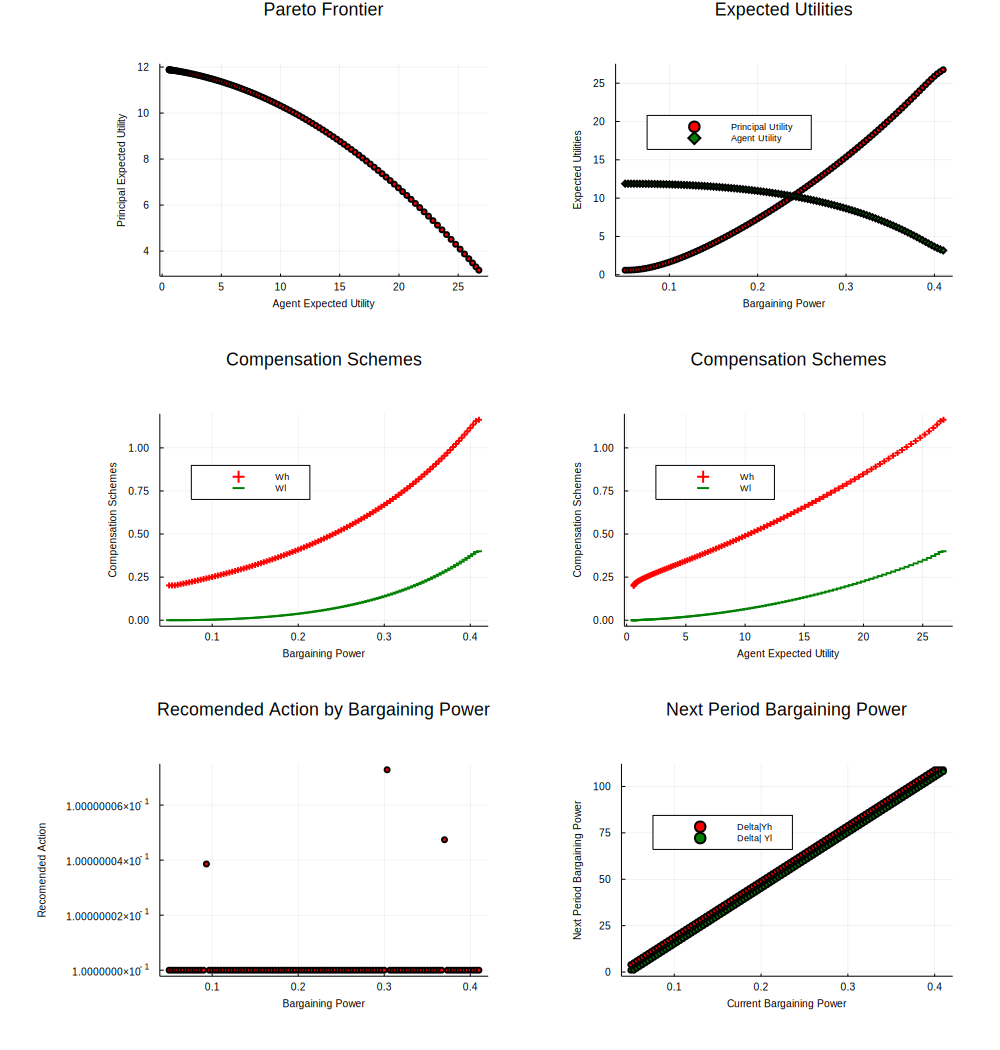

In [38]:
using Plots, Plots.PlotMeasures    # Plots packages load
theme(:default)     # Graphics theme
palette = get(ColorSchemes.Blues_8, [i/4 for i in 1:4])

#Read data to plot 
#DataEstPoint_MOWS = DataFrame(XLSX.readtable("Wangs Utility Function/Bargaining_Dynamic/Wang_eps005.xlsx", "Sheet1")...)

#Recomended Action by bargaining power plot.
pl1=scatter(DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Accion_Recomendada"], 
    color = [:red],

    legend = false,
    title = "Recomended Action by Bargaining Power", 
    xlabel = "Bargaining Power",
    ylabel =  "Recomended Action")

#Pareto Frontier Plot 
pl2=scatter(DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Principal"],
    color = [:red],
    legend = false,
    title = "Pareto Frontier", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Principal Expected Utility") 

#Compensation Schemes by bargaining power plot. 
pl3=scatter([DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Deltas"]], [DataEstPoint_MOWS[:, "Compensacion_YH"], DataEstPoint_MOWS[:, "Compensacion_YL"]],
    color = [:red :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Bargaining Power",
    ylabel =  "Compensation Schemes")

#Compensation Schemes by agent utility plot. 
pl4=scatter([DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Agente"]], [DataEstPoint_MOWS[:, "Compensacion_YH"], DataEstPoint_MOWS[:, "Compensacion_YL"]],
    color = [:red :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Compensation Schemes")

#Expected Agent and Principal utilities plot.
pl5=scatter([DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Deltas"]], [DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Principal"]],
    color = [:red :green],
    shape = [:circle :diamond :utri],
    labels = ["Principal Utility" "Agent Utility"],
    legend = :topleft,
    title = "Expected Utilities", 
    xlabel = "Bargaining Power",
    ylabel =  "Expected Utilities", 
    markersize = 2)  

#Next Period bargaining powers plot.
pl6=scatter(
    [DataEstPoint_MOWS[:, 1], DataEstPoint_MOWS[:, 1]],
    [DataEstPoint_MOWS[:, "DFH"], DataEstPoint_MOWS[:, "DFL"]],
    #markersize = 2, 
    labels = ["Delta|Yh" "Delta| Yl"],
    color = [:red :green],
    title = "Next Period Bargaining Power", 
    legend = :topleft,
    xlabel = "Current Bargaining Power",
    ylabel =  "Next Period Bargaining Power") 

#Layout
l = @layout [a b; c d; e f]

#Figure 
complete_plot = plot(pl2, pl5, pl3, pl4, pl1, pl6, layout = l,
    size = (1000,1050),
    #dpi = 1000,
    xtickfont = font(7), 
    ytickfont = font(7), 
    guidefont = font(7), 
    titlefont = font(12),
    legendfont = font(6),
    markersize = 3,
    margin = 10mm) 
display(complete_plot)

#Save figure 
#savefig("Continuous_Actions/Prueba5_eps01")